# Import Liblary

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder


- Membaca Dataset Untuk Pelatihan model yang memiliki format .csv yang bisa di unduh pada [link dataset ini](https://docs.google.com/document/d/1bG1j4HuzU7JgEn9v-LXKGx2sbqiFmaEl/edit?usp=sharing&ouid=106429149900645652968&rtpof=true&sd=true)

In [33]:
weather = pd.read_csv("../Dataset/Raw_Data/weather_dataset.csv") 
road = pd.read_csv("../Dataset/Raw_Data/road_condition_dataset.csv")
equipment = pd.read_csv("../Dataset/Raw_Data/heavy_equipment_dataset.csv")
production = pd.read_csv("../Dataset/Raw_Data/production_dataset.csv")
logistics = pd.read_csv("../Dataset/Raw_Data/logistics_dataset.csv")
vessel = pd.read_csv("../Dataset/Raw_Data/vessel_schedule_dataset.csv")

### fungsi evaluasi model dan visulisasi distribusi kelas 
- distribusi kelas atau fungsi (plot_class_distribution) bertujuan agar dapat melihat keseimbangan label klasifikasi yang merata
- visulisasi akurasi atau fungsi (check_overfitting_pipeline) bertujuan mengecheck apakah model overfiting untuk melihat curve pembelajaran model serta akurasi dan error pada model yang dibuat

In [34]:

def plot_class_distribution(df, column, title=None, palette='Set2'):
    
    # Jika tidak ada judul, buat otomatis
    if title is None:
        title = f"Distribusi Kolom: {column}"
    
    # Visualisasi countplot
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=column, palette=palette)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    
    # Tampilkan jumlah per kelas di terminal
    print("Jumlah data per kelas:")
    print(df[column].value_counts())

In [35]:
def check_overfitting_pipeline(model_pipeline, X_train, X_test, y_train, y_test):
    """
    Mengecek potensi overfitting atau underfitting pada model pipeline.
    
    Parameter:
    - model_pipeline : Pipeline (contoh: model_equipment)
    - X_train, X_test, y_train, y_test : Data hasil split
    """

    # --- Prediksi Training & Testing ---
    y_pred_train = model_pipeline.predict(X_train)
    y_pred_test = model_pipeline.predict(X_test)

    # --- Hitung Akurasi ---
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # --- Tampilkan Evaluasi Dasar ---
    print("="*65)
    print("🔍 HASIL EVALUASI MODEL PIPELINE")
    print("="*65)
    print(f"Akurasi Training : {train_acc:.4f}")
    print(f"Akurasi Testing  : {test_acc:.4f}")
    print("\n📊 Laporan Klasifikasi (Testing):")
    print(classification_report(y_test, y_pred_test))
    print("="*65)

    # --- 4Analisis Overfitting/Underfitting ---
    gap = train_acc - test_acc
    if gap > 0.1:
        print("⚠️  Model kemungkinan **Overfitting** (Training jauh lebih tinggi dari Testing)")
    elif gap < -0.05:
        print("❗ Model kemungkinan **Underfitting** (Testing lebih tinggi dari Training — tidak umum)")
    else:
        print("✅ Model memiliki **Generalization** yang baik")
    print("="*65)

    # --- Visualisasi Akurasi Train vs Test ---
    plt.figure(figsize=(6,4))
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['#4CAF50', '#2196F3'])
    plt.title('Perbandingan Akurasi Train vs Test')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    # --- Learning Curve (untuk analisis lebih lanjut) ---
    X_all = pd.concat([X_train, X_test])
    y_all = pd.concat([y_train, y_test])

    train_sizes, train_scores, test_scores = learning_curve(
        model_pipeline, 
        X_all, 
        y_all, 
        cv=5, 
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy',
        n_jobs=-1
    )

    # --- Visualisasi Learning Curve ---
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Test Accuracy')
    plt.title('Learning Curve (Pipeline Model)')
    plt.xlabel('Jumlah Data Training')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.grid(True)
    plt.show()

# Weather Proses 

In [36]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                20000 non-null  object 
 1   Temperature_C       20000 non-null  float64
 2   Humidity_Percent    20000 non-null  float64
 3   Rainfall_mm         20000 non-null  float64
 4   Wind_Speed_mps      20000 non-null  float64
 5   Wind_Direction_deg  20000 non-null  int64  
 6   Visibility_km       20000 non-null  float64
 7   Pressure_hPa        20000 non-null  float64
 8   Sea_State_Level     20000 non-null  int64  
 9   Wave_Height_m       20000 non-null  float64
 10  Tide_Level_m        20000 non-null  float64
 11  Storm_Warning       20000 non-null  int64  
 12  Weather_Condition   20000 non-null  object 
 13  Weather_Risk_Level  20000 non-null  object 
dtypes: float64(8), int64(3), object(3)
memory usage: 2.1+ MB


In [37]:
weather.shape

(20000, 14)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


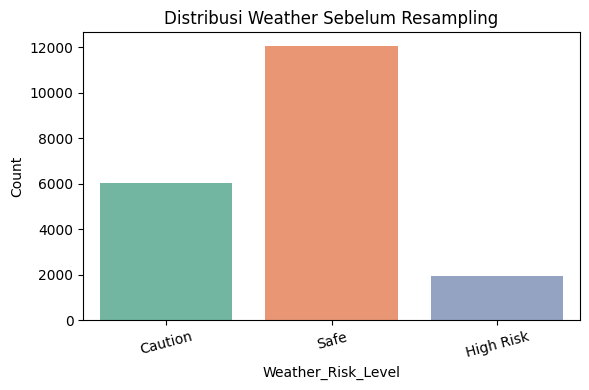

Jumlah data per kelas:
Weather_Risk_Level
Safe         12052
Caution       6023
High Risk     1925
Name: count, dtype: int64


In [38]:
# melihat Persebaran Distribusi kelas sebelum resampling
plot_class_distribution(weather, 'Weather_Risk_Level', title='Distribusi Weather Sebelum Resampling')

In [39]:
# proses resampling untuk mengatasi class imbalance

safe = weather[weather['Weather_Risk_Level'] == 'Safe']
caution = weather[weather['Weather_Risk_Level'] == 'Caution']
high = weather[weather['Weather_Risk_Level'] == 'High Risk']

n_target = max(len(safe), len(caution), len(high))

# Oversampling manual agar semua sama
safe_bal = resample(safe, replace=True, n_samples=n_target, random_state=42)
caution_bal = resample(caution, replace=True, n_samples=n_target, random_state=42)
high_bal = resample(high, replace=True, n_samples=n_target, random_state=42)


# Gabungkan kembali
weather= pd.concat([safe_bal, caution_bal, high_bal])
print(weather.shape)
# Cek hasil
print(weather['Weather_Risk_Level'].value_counts())


(36156, 14)
Weather_Risk_Level
Safe         12052
Caution      12052
High Risk    12052
Name: count, dtype: int64


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


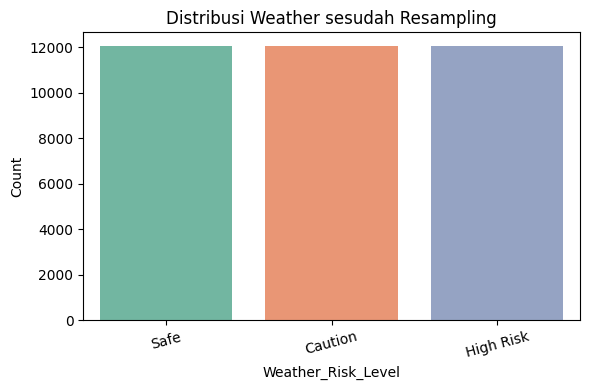

Jumlah data per kelas:
Weather_Risk_Level
Safe         12052
Caution      12052
High Risk    12052
Name: count, dtype: int64


In [40]:
# sesudah resampling 
plot_class_distribution(weather, 'Weather_Risk_Level', title='Distribusi Weather sesudah Resampling')

### Pelatihan Model Untuk Wheather

In [41]:
X = weather.drop(columns=['Date', 'Weather_Risk_Level'])
y = weather['Weather_Risk_Level']

In [42]:
Features_weather = X.columns.tolist()
print(Features_weather)

['Temperature_C', 'Humidity_Percent', 'Rainfall_mm', 'Wind_Speed_mps', 'Wind_Direction_deg', 'Visibility_km', 'Pressure_hPa', 'Sea_State_Level', 'Wave_Height_m', 'Tide_Level_m', 'Storm_Warning', 'Weather_Condition']


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [45]:
model_Weather = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_Weather.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluasi Wheater

🔍 HASIL EVALUASI MODEL PIPELINE
Akurasi Training : 1.0000
Akurasi Testing  : 0.9062

📊 Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

     Caution       0.88      0.84      0.86      2410
   High Risk       1.00      1.00      1.00      2411
        Safe       0.84      0.88      0.86      2411

    accuracy                           0.91      7232
   macro avg       0.91      0.91      0.91      7232
weighted avg       0.91      0.91      0.91      7232

✅ Model memiliki **Generalization** yang baik


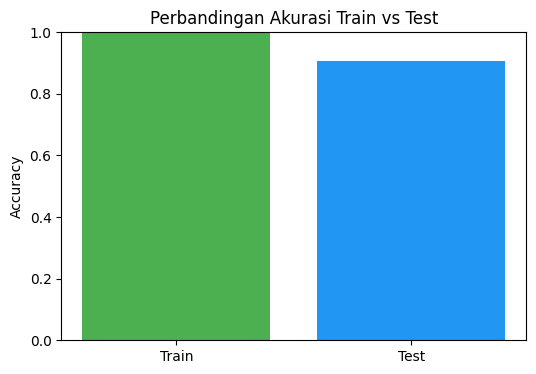

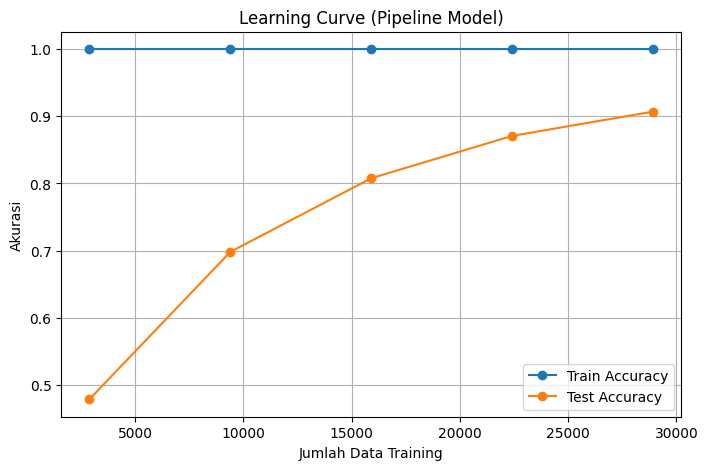

In [46]:
check_overfitting_pipeline(model_Weather, X_train, X_test, y_train, y_test)

# Road Proses

In [47]:
road.head()

,Date,Surface_Type,Surface_Condition,Pothole_Density,Slope_Angle_Degrees,Traffic_Density,Flood_Level_m,Access_Status,Dust_Level_PPM,Ground_Vibration_mm_s,Road_Temperature_C,Rainfall_mm,Soil_Moisture_%,Maintenance_Activity,Accident_Count,Road_Condition_Status
0,2025-01-01 00:00:00,Soil,Dry,14.28,11.81,56.03,1.81,Safe,357.51,28.35,50.39,47.53,36.4,NaN,0,Operational
1,2025-01-01 01:00:00,Mud,Wet,7.84,20.42,33.98,1.28,Under Repair,206.99,0.82,38.54,15.85,57.0,Ongoing,0,Severely Damaged
2,2025-01-01 02:00:00,Asphalt,Dry,3.83,21.88,37.26,1.02,Safe,278.00,3.59,36.08,47.91,8.7,NaN,0,Operational
3,2025-01-01 03:00:00,Asphalt,Dry,1.80,12.24,23.35,1.07,Safe,149.40,24.03,37.72,0.80,24.5,NaN,0,Operational
4,2025-01-01 04:00:00,Asphalt,Dry,6.88,18.12,16.71,0.69,Safe,449.13,23.46,55.28,3.56,8.7,NaN,0,Operational


### Pengecekan, pembersihan dan proses resampling Data 

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


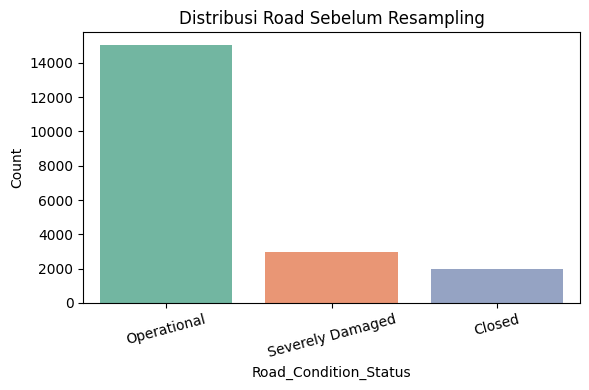

Jumlah data per kelas:
Road_Condition_Status
Operational         15035
Severely Damaged     2963
Closed               2002
Name: count, dtype: int64


In [48]:
plot_class_distribution(road, 'Road_Condition_Status', title='Distribusi Road Sebelum Resampling')

In [49]:
# melakukan pembersihan data pada dataset road condition
road.dropna(inplace=True)
road.drop_duplicates(inplace=True)

In [50]:
road.isnull().sum()

Date                     0
Surface_Type             0
Surface_Condition        0
Pothole_Density          0
Slope_Angle_Degrees      0
Traffic_Density          0
Flood_Level_m            0
Access_Status            0
Dust_Level_PPM           0
Ground_Vibration_mm_s    0
Road_Temperature_C       0
Rainfall_mm              0
Soil_Moisture_%          0
Maintenance_Activity     0
Accident_Count           0
Road_Condition_Status    0
dtype: int64

In [51]:
road.duplicated().sum()

np.int64(0)

In [52]:
operational = road[road['Road_Condition_Status'] == 'Operational']
sev_dam = road[road['Road_Condition_Status'] == 'Severely Damaged']
Closed = road[road['Road_Condition_Status'] == 'Closed']

n_target = max(len(operational), len(sev_dam), len(Closed))

# Oversampling manual agar semua sama
operational_bal = resample(operational, replace=True, n_samples=n_target, random_state=42)
sev_dam_bal = resample(sev_dam, replace=True, n_samples=n_target, random_state=42)
Closed_bal = resample(Closed, replace=True, n_samples=n_target, random_state=42)


# Gabungkan kembali
road = pd.concat([operational_bal, sev_dam_bal,Closed_bal])
print(road.shape)
# Cek hasil
print(road['Road_Condition_Status'].value_counts())

(13464, 16)
Road_Condition_Status
Operational         4488
Severely Damaged    4488
Closed              4488
Name: count, dtype: int64


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


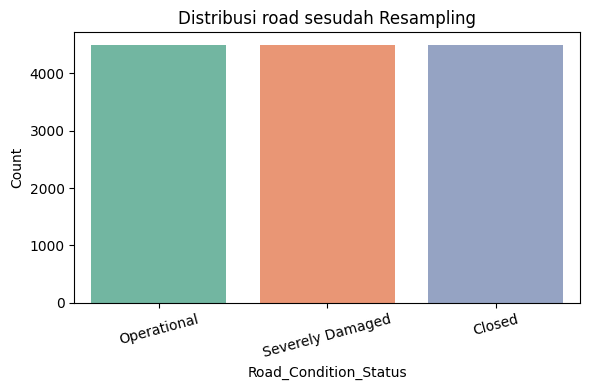

Jumlah data per kelas:
Road_Condition_Status
Operational         4488
Severely Damaged    4488
Closed              4488
Name: count, dtype: int64


In [53]:
plot_class_distribution(road, 'Road_Condition_Status', title='Distribusi road sesudah Resampling')

### Pelatihan Model Untuk Road

In [54]:
X = road.drop(columns=['Date', 'Road_Condition_Status'])
y = road['Road_Condition_Status']

In [55]:
Features_road = X.columns.tolist()
print(Features_road)

['Surface_Type', 'Surface_Condition', 'Pothole_Density', 'Slope_Angle_Degrees', 'Traffic_Density', 'Flood_Level_m', 'Access_Status', 'Dust_Level_PPM', 'Ground_Vibration_mm_s', 'Road_Temperature_C', 'Rainfall_mm', 'Soil_Moisture_%', 'Maintenance_Activity', 'Accident_Count']


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [58]:
model_road = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_road.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluasi Model Road

🔍 HASIL EVALUASI MODEL PIPELINE
Akurasi Training : 1.0000
Akurasi Testing  : 0.9874

📊 Laporan Klasifikasi (Testing):
                  precision    recall  f1-score   support

          Closed       1.00      1.00      1.00       897
     Operational       0.98      0.98      0.98       898
Severely Damaged       0.99      0.98      0.99       898

        accuracy                           0.99      2693
       macro avg       0.99      0.99      0.99      2693
    weighted avg       0.99      0.99      0.99      2693

✅ Model memiliki **Generalization** yang baik


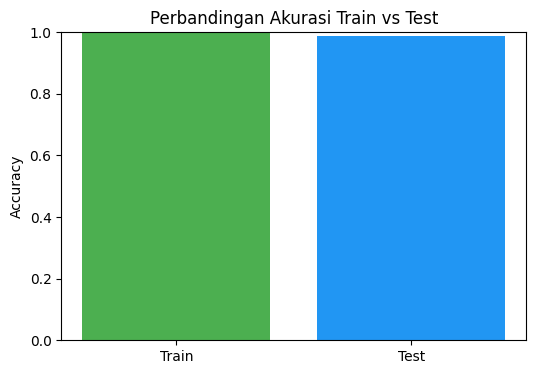

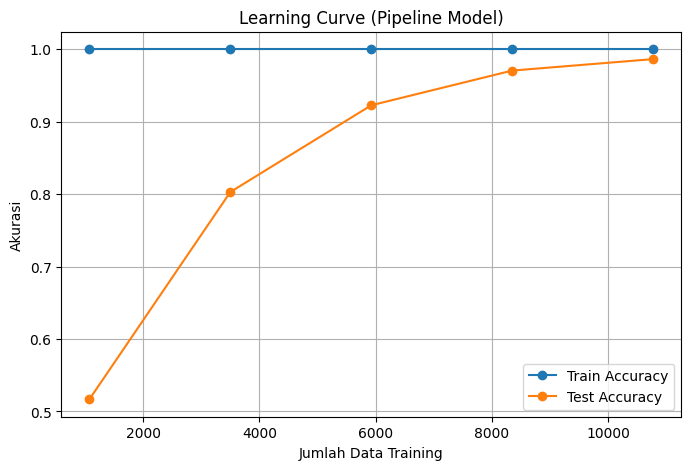

In [59]:
check_overfitting_pipeline(model_road, X_train, X_test, y_train, y_test)

# Proses Heavy Equipment 

In [60]:
equipment.head()

,Timestamp,Machine_ID,Machine_Type,Engine_Temperature_C,Oil_Pressure_Bar,Fuel_Level_Percent,Engine_RPM,Vibration_Level_g,Hydraulic_Pressure_Bar,Working_Hours,Maintenance_Status,Fault_Code,Operational_Mode,Ambient_Temperature_C,Operator_ID,Gear_Position,Fuel_Consumption_L_h,Torque_Nm,Engine_Load_Percent,Machine_Failure
0,2025-01-01 00:00:00,MCH_915,Dump Truck,114.11,3.71,61.1,2564,2.58,96.59,10747.0,Normal,4,Load,26.9,OP_49,1,30.56,1033.48,62.5,0
1,2025-01-01 01:00:00,MCH_720,Loader,61.48,1.99,71.4,2947,2.98,88.85,9322.5,Overdue,4,Idle,35.4,OP_49,1,55.99,388.45,52.2,0
2,2025-01-01 02:00:00,MCH_308,Bulldozer,109.58,1.67,95.9,1476,1.05,204.42,7016.7,Normal,2,Idle,39.8,OP_44,2,18.51,199.82,56.8,0
3,2025-01-01 03:00:00,MCH_903,Dump Truck,114.89,2.78,19.2,1167,1.93,157.18,9445.9,Normal,8,Dumping,30.8,OP_3,1,33.37,147.16,56.8,0
4,2025-01-01 04:00:00,MCH_185,Bulldozer,88.67,4.20,92.9,1162,3.42,265.52,1601.4,Normal,2,Load,37.6,OP_5,3,17.48,746.35,51.4,0


In [61]:
equipment.drop(columns=['Timestamp','Machine_ID','Operator_ID'], inplace=True)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


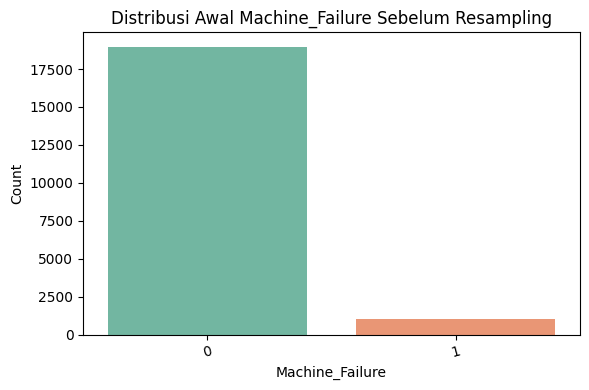

Jumlah data per kelas:
Machine_Failure
0    18967
1     1033
Name: count, dtype: int64


In [62]:
plot_class_distribution(equipment, 'Machine_Failure', title='Distribusi Awal Machine_Failure Sebelum Resampling')

In [63]:
equipment.dropna(inplace=True)
equipment.drop_duplicates(inplace=True)


In [64]:
equipment.isnull().sum()

Machine_Type              0
Engine_Temperature_C      0
Oil_Pressure_Bar          0
Fuel_Level_Percent        0
Engine_RPM                0
Vibration_Level_g         0
Hydraulic_Pressure_Bar    0
Working_Hours             0
Maintenance_Status        0
Fault_Code                0
Operational_Mode          0
Ambient_Temperature_C     0
Gear_Position             0
Fuel_Consumption_L_h      0
Torque_Nm                 0
Engine_Load_Percent       0
Machine_Failure           0
dtype: int64

In [65]:
equipment.duplicated().sum()

np.int64(0)

In [66]:
Yes = equipment[equipment['Machine_Failure'] == 1]
No = equipment[equipment['Machine_Failure'] == 0]


n_target = max(len(Yes), len(No))

# Oversampling manual agar semua sama
Yes_bal = resample(Yes, replace=True, n_samples=n_target, random_state=42)
No_bal = resample(No, replace=True, n_samples=n_target, random_state=42)



# Gabungkan kembali
equipment = pd.concat([Yes_bal, No_bal])
print(equipment.shape)
# Cek hasil
print(equipment['Machine_Failure'].value_counts())

(37934, 17)
Machine_Failure
1    18967
0    18967
Name: count, dtype: int64


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


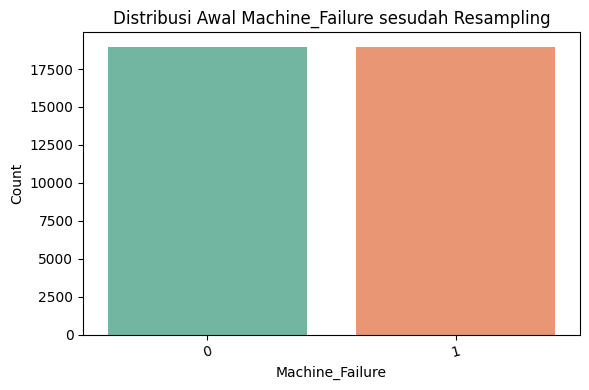

Jumlah data per kelas:
Machine_Failure
1    18967
0    18967
Name: count, dtype: int64


In [67]:
plot_class_distribution(equipment, 'Machine_Failure', title='Distribusi Awal Machine_Failure sesudah Resampling')

In [68]:
equipment.head()

,Machine_Type,Engine_Temperature_C,Oil_Pressure_Bar,Fuel_Level_Percent,Engine_RPM,Vibration_Level_g,Hydraulic_Pressure_Bar,Working_Hours,Maintenance_Status,Fault_Code,Operational_Mode,Ambient_Temperature_C,Gear_Position,Fuel_Consumption_L_h,Torque_Nm,Engine_Load_Percent,Machine_Failure
16369,Excavator,80.93,5.36,33.3,868,0.16,166.66,9765.9,Normal,1,Idle,41.0,2,27.47,271.99,63.0,1
2730,Dump Truck,63.80,4.06,56.0,2473,1.46,126.10,2636.9,Normal,1,Idle,38.2,1,59.31,957.14,47.9,1
8878,Excavator,102.94,5.94,27.6,1260,2.49,178.01,9400.7,Normal,3,Load,44.9,1,50.92,387.96,84.1,1
6471,Dump Truck,60.82,5.95,43.0,2577,2.91,187.29,2035.6,Normal,1,Load,44.4,4,20.10,857.66,12.4,1
1962,Dump Truck,68.27,4.53,22.3,2681,4.72,154.40,11504.7,Normal,2,Dumping,40.3,2,25.73,1462.68,60.7,1


In [69]:
X = equipment.drop(columns=['Machine_Failure'])
y = equipment['Machine_Failure']

In [70]:
Features_equipment = X.columns.tolist()
print(Features_equipment)

['Machine_Type', 'Engine_Temperature_C', 'Oil_Pressure_Bar', 'Fuel_Level_Percent', 'Engine_RPM', 'Vibration_Level_g', 'Hydraulic_Pressure_Bar', 'Working_Hours', 'Maintenance_Status', 'Fault_Code', 'Operational_Mode', 'Ambient_Temperature_C', 'Gear_Position', 'Fuel_Consumption_L_h', 'Torque_Nm', 'Engine_Load_Percent']


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [72]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [73]:
model_equipment = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_equipment.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluasi Model equipment

🔍 HASIL EVALUASI MODEL PIPELINE
Akurasi Training : 1.0000
Akurasi Testing  : 1.0000

📊 Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3794
           1       1.00      1.00      1.00      3793

    accuracy                           1.00      7587
   macro avg       1.00      1.00      1.00      7587
weighted avg       1.00      1.00      1.00      7587

✅ Model memiliki **Generalization** yang baik


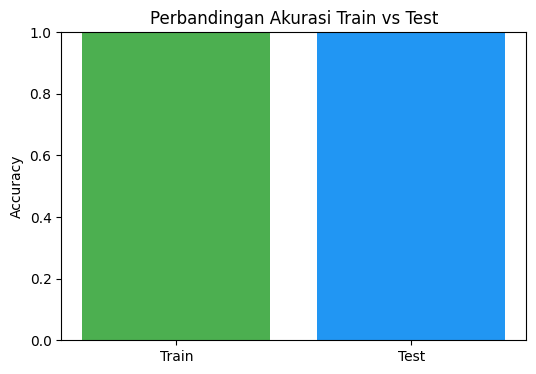

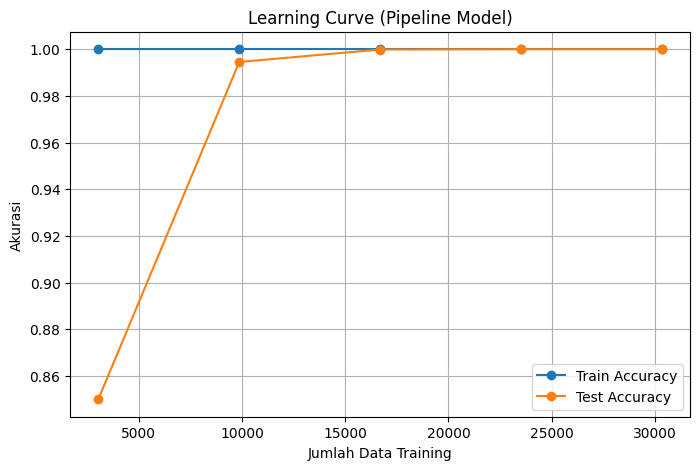

In [74]:
check_overfitting_pipeline(model_equipment, X_train, X_test, y_train, y_test)

## Preprocessing Vessel + Train Model

In [75]:
vessel.head()

,Record_Timestamp,Vessel_ID,Route_Code,Departure_Time,Planned_Arrival_Time,Actual_Arrival_Time,Delay_Minutes,Cargo_Type,Load_Weight_Tons,Port_Condition,Weather_Impact_Score,Sea_Condition_Code,Crew_Availability_Percent,Vessel_Status,Fuel_Consumption_Tons,Engine_RPM,Distance_Traveled_km,Average_Speed_knots,Delay_Risk
0,2025-01-01 00:00:00,VS_31,R2,2025-01-01 00:00:00,2025-01-01 08:00:00,2025-01-01 12:19:55,116.1,Coal,1129.6,Normal,0.44,Calm,82.5,Docked,44.37,617,404.3,8.34,On Time
1,2025-01-01 01:00:00,VS_160,R1,2025-01-01 01:00:00,2025-01-01 09:00:00,2025-01-01 06:31:24,86.2,Iron Sand,1171.2,Congested,0.13,Calm,89.7,Delayed,29.86,679,32.0,21.05,On Time
2,2025-01-01 02:00:00,VS_40,R5,2025-01-01 02:00:00,2025-01-01 10:00:00,2025-01-01 08:00:24,-12.6,Nickel,2534.7,Normal,0.17,Calm,72.3,Sailing,23.48,718,226.9,10.68,On Time
3,2025-01-01 03:00:00,VS_169,R3,2025-01-01 03:00:00,2025-01-01 11:00:00,2025-01-01 11:32:17,-38.3,Coal,3335.8,Normal,0.84,Moderate,70.9,Sailing,73.97,491,114.3,18.85,On Time
4,2025-01-01 04:00:00,VS_78,R1,2025-01-01 04:00:00,2025-01-01 12:00:00,2025-01-01 10:42:47,91.0,Coal,3699.8,Normal,0.05,Moderate,72.1,Sailing,19.28,578,263.3,6.59,On Time


In [76]:
vessel.drop(columns=['Record_Timestamp','Vessel_ID','Route_Code','Actual_Arrival_Time'],inplace=True)

In [77]:
vessel['Departure_Time'] = pd.to_datetime(vessel['Departure_Time'])
vessel['Planned_Arrival_Time'] = pd.to_datetime(vessel['Planned_Arrival_Time'])


# Jam keberangkatan (0–23)
vessel['Departure_Hour'] = vessel['Departure_Time'].dt.hour

# Hari keberangkatan (Senin=0, Minggu=6)
vessel['Departure_Weekday'] = vessel['Departure_Time'].dt.dayofweek

# Bulan keberangkatan (1–12)
vessel['Departure_Month'] = vessel['Departure_Time'].dt.month

# Durasi perjalanan terencana (dalam jam)
vessel['Planned_Duration_hours'] = (
    (vessel['Planned_Arrival_Time'] - vessel['Departure_Time']).dt.total_seconds() / 3600
)

# Hapus kolom waktu mentah setelah diturunkan
vessel = vessel.drop(['Departure_Time', 'Planned_Arrival_Time'], axis=1)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


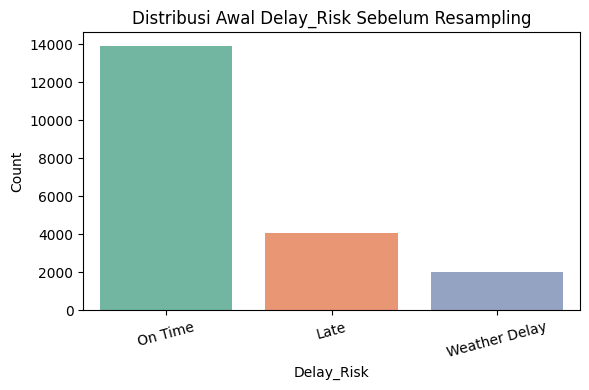

Jumlah data per kelas:
Delay_Risk
On Time          13931
Late              4071
Weather Delay     1998
Name: count, dtype: int64


In [78]:
plot_class_distribution(vessel, 'Delay_Risk', title='Distribusi Awal Delay_Risk Sebelum Resampling')

In [79]:
on_time = vessel[vessel['Delay_Risk'] == 'On Time']
late = vessel[vessel['Delay_Risk'] == 'Late']
weather_delay = vessel[vessel['Delay_Risk'] == 'Weather Delay']

n_target = max(len(on_time), len(late), len(weather_delay))

# Oversampling manual agar semua sama
ontime_bal = resample(on_time, replace=True, n_samples=n_target, random_state=42)
late_bal = resample(late, replace=True, n_samples=n_target, random_state=42)
weatherdelay_bal = resample(weather_delay, replace=True, n_samples=n_target, random_state=42)


# Gabungkan kembali
vessel= pd.concat([ontime_bal, late_bal, weatherdelay_bal])
print(vessel.shape)
# Cek hasil
print(vessel['Delay_Risk'].value_counts())


(41793, 17)
Delay_Risk
On Time          13931
Late             13931
Weather Delay    13931
Name: count, dtype: int64


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


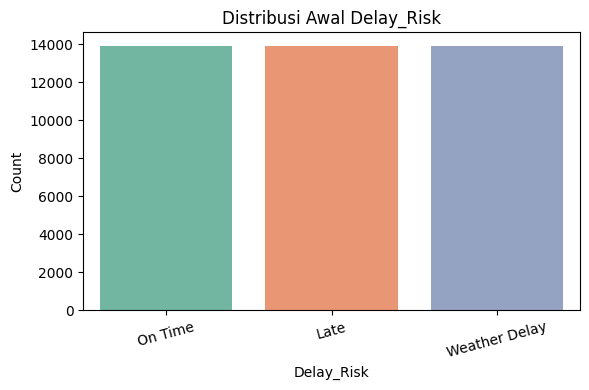

Jumlah data per kelas:
Delay_Risk
On Time          13931
Late             13931
Weather Delay    13931
Name: count, dtype: int64


In [80]:
plot_class_distribution(vessel, 'Delay_Risk', title='Distribusi Awal Delay_Risk')

In [81]:
X = vessel.drop(columns=['Delay_Risk'])
y = vessel['Delay_Risk']

In [82]:
Features_vessel = X.columns.tolist()
print(Features_vessel)

['Delay_Minutes', 'Cargo_Type', 'Load_Weight_Tons', 'Port_Condition', 'Weather_Impact_Score', 'Sea_Condition_Code', 'Crew_Availability_Percent', 'Vessel_Status', 'Fuel_Consumption_Tons', 'Engine_RPM', 'Distance_Traveled_km', 'Average_Speed_knots', 'Departure_Hour', 'Departure_Weekday', 'Departure_Month', 'Planned_Duration_hours']


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [84]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [85]:
model_vessel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_vessel.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## evaluasi model vessel

🔍 HASIL EVALUASI MODEL PIPELINE
Akurasi Training : 1.0000
Akurasi Testing  : 0.9688

📊 Laporan Klasifikasi (Testing):
               precision    recall  f1-score   support

         Late       0.97      0.95      0.96      2786
      On Time       0.94      0.97      0.95      2786
Weather Delay       1.00      0.99      1.00      2787

     accuracy                           0.97      8359
    macro avg       0.97      0.97      0.97      8359
 weighted avg       0.97      0.97      0.97      8359

✅ Model memiliki **Generalization** yang baik


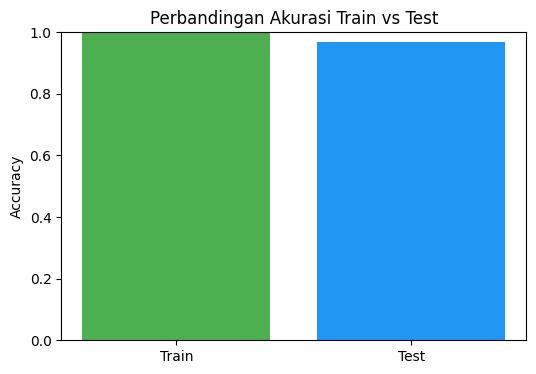

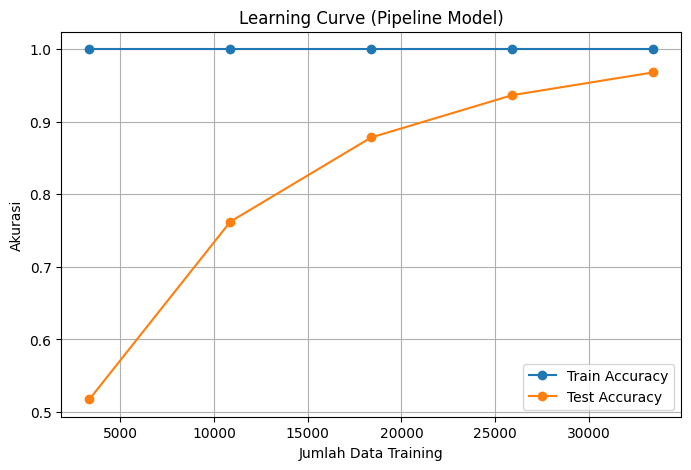

In [86]:
check_overfitting_pipeline(model_vessel, X_train, X_test, y_train, y_test)

## Preprocessing Logistics + train model

In [87]:
logistics.head()

,Record_Timestamp,Logistics_ID,Date,Route_Code,Origin_Location,Destination_Location,Cargo_Type,Cargo_Weight_Tons,Transport_Mode,Vessel_ID,...,Distance_km,Travel_Time_hr,Actual_Travel_Time_hr,Fuel_Used_Liters,Fuel_Cost_USD,Delivery_Status,Delay_Cause,CO2_Emission_kg,Driver_ID,Delivery_Risk_Level
0,2025-01-01 00:00:00,LG_1,2025-01-01,R2,Warehouse C,Smelter Gamma,Iron Sand,4539.8,Truck,VS_66,...,392.9,56.9,56.9,903.4,1094.23,Delivered,Mechanical,1549.7,DRV_298,Low
1,2025-01-01 01:00:00,LG_2,2025-01-01,R1,Mine B,Smelter Gamma,General Cargo,665.8,Truck,VS_79,...,754.0,69.4,3.4,1364.2,4208.12,Cancelled,Traffic,2947.6,DRV_167,Low
2,2025-01-01 02:00:00,LG_3,2025-01-01,R4,Mine B,Warehouse Delta,Nickel,3708.0,Vessel,VS_89,...,822.1,27.9,68.9,686.8,1581.14,Delivered,Road,2682.5,DRV_256,Medium
3,2025-01-01 03:00:00,LG_4,2025-01-01,R5,Mine B,Smelter Gamma,Iron Sand,2037.0,Train,VS_192,...,70.6,10.1,41.7,1281.3,392.16,In Transit,NaN,1196.2,DRV_115,Medium
4,2025-01-01 04:00:00,LG_5,2025-01-01,R3,Processing Plant,Warehouse Delta,Nickel,4509.3,Vessel,VS_135,...,29.0,33.8,13.7,1756.5,3314.94,Delivered,NaN,1512.2,DRV_26,Medium


In [88]:
logistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Record_Timestamp       20000 non-null  object 
 1   Logistics_ID           20000 non-null  object 
 2   Date                   20000 non-null  object 
 3   Route_Code             20000 non-null  object 
 4   Origin_Location        20000 non-null  object 
 5   Destination_Location   20000 non-null  object 
 6   Cargo_Type             20000 non-null  object 
 7   Cargo_Weight_Tons      20000 non-null  float64
 8   Transport_Mode         20000 non-null  object 
 9   Vessel_ID              20000 non-null  object 
 10  Machine_ID             20000 non-null  object 
 11  Distance_km            20000 non-null  float64
 12  Travel_Time_hr         20000 non-null  float64
 13  Actual_Travel_Time_hr  20000 non-null  float64
 14  Fuel_Used_Liters       20000 non-null  float64
 15  Fu

In [89]:
logistics.drop(columns=['Record_Timestamp', 'Logistics_ID', 'Vessel_ID', 'Machine_ID', 'Driver_ID'], inplace=True)


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


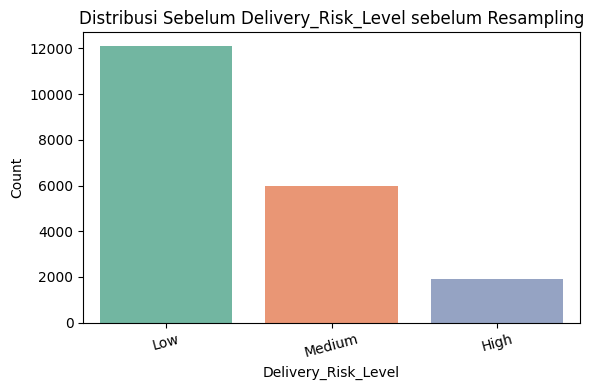

Jumlah data per kelas:
Delivery_Risk_Level
Low       12101
Medium     5971
High       1928
Name: count, dtype: int64


In [90]:
plot_class_distribution(logistics, 'Delivery_Risk_Level', title='Distribusi Sebelum Delivery_Risk_Level sebelum Resampling')

In [91]:
high = logistics[logistics['Delivery_Risk_Level'] == 'High']
medium = logistics[logistics['Delivery_Risk_Level'] == 'Medium']
Low = logistics[logistics['Delivery_Risk_Level'] == 'Low']

n_target = max(len(high), len(medium), len(Low))

# Oversampling manual agar semua sama
high_bal = resample(high, replace=True, n_samples=n_target, random_state=42)
medium_bal = resample(medium, replace=True, n_samples=n_target, random_state=42)
Low_bal = resample(Low, replace=True, n_samples=n_target, random_state=42)


# Gabungkan kembali
logistics = pd.concat([high_bal, medium_bal,Low_bal])
print(logistics.shape)
# Cek hasil
print(logistics['Delivery_Risk_Level'].value_counts())

(36303, 16)
Delivery_Risk_Level
High      12101
Medium    12101
Low       12101
Name: count, dtype: int64


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


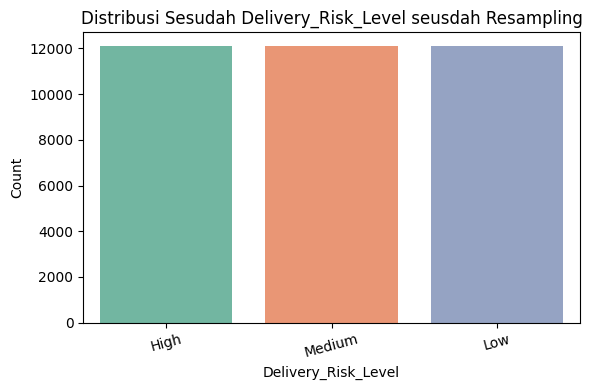

Jumlah data per kelas:
Delivery_Risk_Level
High      12101
Medium    12101
Low       12101
Name: count, dtype: int64


In [92]:
plot_class_distribution(logistics, 'Delivery_Risk_Level', title='Distribusi Sesudah Delivery_Risk_Level seusdah Resampling')

In [93]:
X = logistics.drop(columns=['Delivery_Risk_Level'])
y = logistics['Delivery_Risk_Level']

In [94]:
Features_logistics = X.columns.tolist()
print(Features_logistics)

['Date', 'Route_Code', 'Origin_Location', 'Destination_Location', 'Cargo_Type', 'Cargo_Weight_Tons', 'Transport_Mode', 'Distance_km', 'Travel_Time_hr', 'Actual_Travel_Time_hr', 'Fuel_Used_Liters', 'Fuel_Cost_USD', 'Delivery_Status', 'Delay_Cause', 'CO2_Emission_kg']


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [96]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

model_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [97]:
model_logistic.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


🔍 HASIL EVALUASI MODEL PIPELINE
Akurasi Training : 1.0000
Akurasi Testing  : 0.9167

📊 Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

        High       1.00      0.99      0.99      2420
         Low       0.84      0.93      0.88      2420
      Medium       0.92      0.83      0.87      2421

    accuracy                           0.92      7261
   macro avg       0.92      0.92      0.92      7261
weighted avg       0.92      0.92      0.92      7261

✅ Model memiliki **Generalization** yang baik


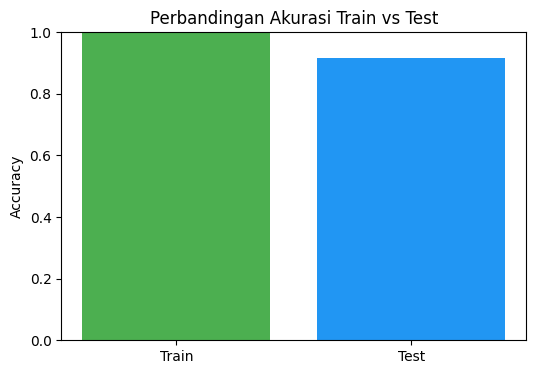

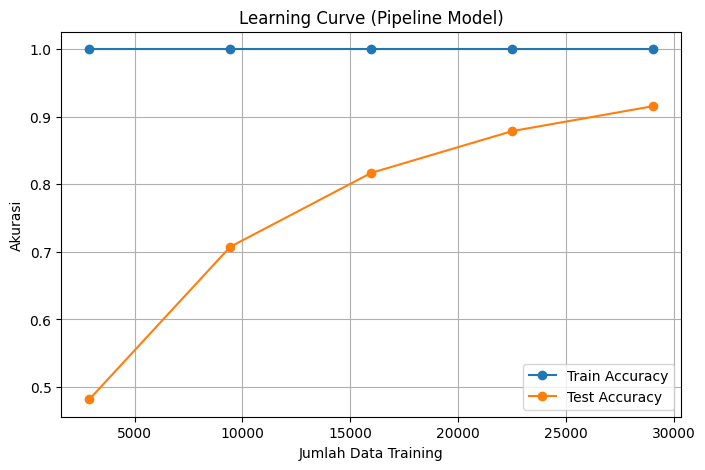

In [98]:
check_overfitting_pipeline(model_logistic, X_train, X_test, y_train, y_test)

### preprocessing Production + Train Model

In [99]:
production.head()

,Record_Timestamp,Production_ID,Date,Machine_ID,Shift,Operator_ID,Material_Type,Working_Hours,Production_Tons,Fuel_Consumed_Liters,...,Weather_Condition,Road_Condition_Status,Equipment_Efficiency_Percent,Fuel_Efficiency_Tons_per_Liter,Incident_Report,Maintenance_Required,CO2_Emission_kg,Production_Risk_Level,Production_Cost_USD,Revenue_USD
0,2025-01-01 00:00:00,PD_1,2025-01-01,MCH_361,Afternoon,OP_20,Iron Sand,10.8,541.7,433.5,...,Foggy,Operational,91.6,1.54,1,0,612.9,Low,11447.63,34938.39
1,2025-01-01 01:00:00,PD_2,2025-01-01,MCH_956,Afternoon,OP_10,Coal,11.9,423.0,100.5,...,Storm,Closed,65.2,4.74,0,0,955.6,High,8433.78,14264.72
2,2025-01-01 02:00:00,PD_3,2025-01-01,MCH_625,Afternoon,OP_35,Nickel,6.5,786.7,507.4,...,Clear,Severely Damaged,65.9,4.82,0,0,870.6,Low,2343.84,12653.18
3,2025-01-01 03:00:00,PD_4,2025-01-01,MCH_460,Night,OP_4,Coal,11.3,498.9,698.7,...,Foggy,Severely Damaged,85.2,4.73,0,0,199.3,Low,13254.65,11364.08
4,2025-01-01 04:00:00,PD_5,2025-01-01,MCH_808,Morning,OP_29,Coal,10.8,809.9,635.7,...,Foggy,Operational,86.3,1.67,0,0,571.7,Medium,18821.19,32540.59


dari dataset di atas dapat dilakukan
- Klasifikasi Risiko Produksi
- Production Risk Level Classification
- Prediksi Produksi (Production_Tons)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


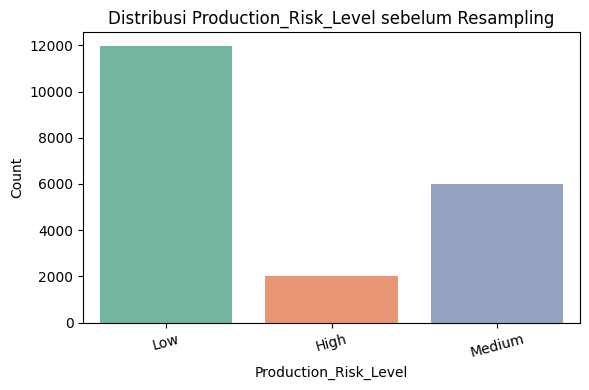

Jumlah data per kelas:
Production_Risk_Level
Low       11962
Medium     6018
High       2020
Name: count, dtype: int64


In [100]:
plot_class_distribution(production, 'Production_Risk_Level', title='Distribusi Production_Risk_Level sebelum Resampling')


In [101]:

high = production[production['Production_Risk_Level'] == 'High']
medium = production[production['Production_Risk_Level'] == 'Medium']
low = production[production['Production_Risk_Level'] == 'Low']

n_target = max(len(high), len(medium), len(low))

high_bal = resample(high, replace=True, n_samples=n_target, random_state=42)
medium_bal = resample(medium, replace=True, n_samples=n_target, random_state=42)
low_bal = resample(low, replace=True, n_samples=n_target, random_state=42)

production = pd.concat([high_bal, medium_bal, low_bal])

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22424\1422389780.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette=palette)


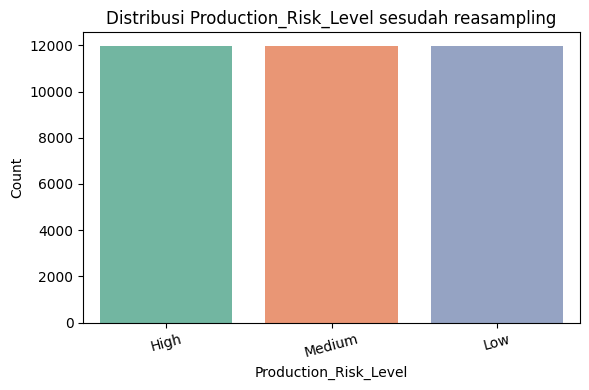

Jumlah data per kelas:
Production_Risk_Level
High      11962
Medium    11962
Low       11962
Name: count, dtype: int64


In [102]:
plot_class_distribution(production, 'Production_Risk_Level', title='Distribusi Production_Risk_Level sesudah reasampling')


In [103]:
X1 = production.drop(columns=['Production_Risk_Level'])
y1 = production['Production_Risk_Level']

num_cols1 = X1.select_dtypes(include=['int64','float64']).columns
cat_cols1 = X1.select_dtypes(include=['object']).columns

preprocessor1 = ColumnTransformer([
    ('num', StandardScaler(), num_cols1),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols1)
])

model1_production = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [104]:
Features_production = X1.columns.tolist()
print(Features_production)

['Record_Timestamp', 'Production_ID', 'Date', 'Machine_ID', 'Shift', 'Operator_ID', 'Material_Type', 'Working_Hours', 'Production_Tons', 'Fuel_Consumed_Liters', 'Downtime_Minutes', 'Weather_Condition', 'Road_Condition_Status', 'Equipment_Efficiency_Percent', 'Fuel_Efficiency_Tons_per_Liter', 'Incident_Report', 'Maintenance_Required', 'CO2_Emission_kg', 'Production_Cost_USD', 'Revenue_USD']


In [105]:
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
    model1_production.fit(X1_train, y1_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


🔍 HASIL EVALUASI MODEL PIPELINE
Akurasi Training : 1.0000
Akurasi Testing  : 0.9250

📊 Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

        High       1.00      0.99      1.00      2400
         Low       0.85      0.95      0.89      2398
      Medium       0.94      0.83      0.88      2380

    accuracy                           0.93      7178
   macro avg       0.93      0.92      0.92      7178
weighted avg       0.93      0.93      0.92      7178

✅ Model memiliki **Generalization** yang baik


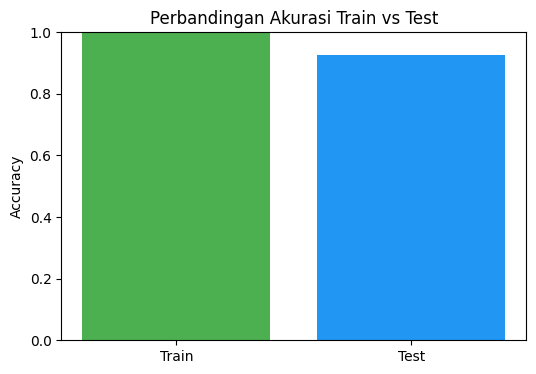

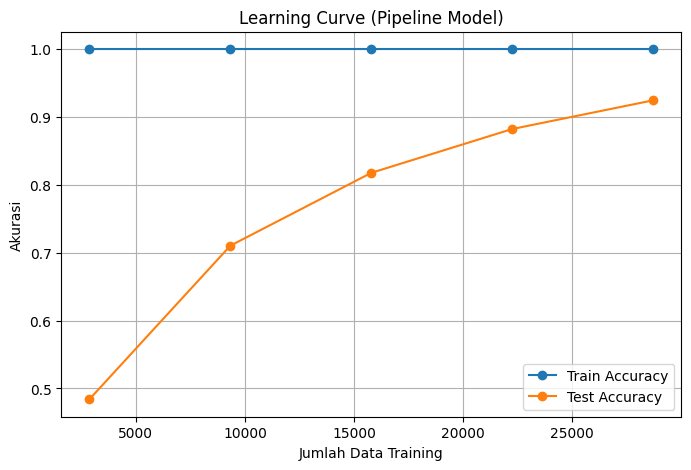

In [106]:
check_overfitting_pipeline(model1_production, X1_train, X1_test, y1_train, y1_test)

### simpan model

In [107]:
import os
import joblib
import pandas as pd

# === Path otomatis ke folder project root (naik 1 level dari notebook) ===
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# === Folder models sesuai struktur folder Anda ===
MODEL_DIR = os.path.join(ROOT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("📁 Model akan disimpan di folder:", MODEL_DIR)

# === Daftar model ===
models_to_save = {
    'model_weather.pkl': {
        "model": model_Weather,
        "features": Features_weather
    },
    'model_road.pkl': {
        "model": model_road,
        "features": Features_road
    },
    'model_equipment.pkl': {
        "model": model_equipment,
        "features": Features_equipment
    },
    'model_vessel.pkl': {
        "model": model_vessel,
        "features": Features_vessel
    },
    'model_logistics.pkl': {
        "model": model_logistic,
        "features": Features_logistics
    },
    'model_production.pkl': {
        "model": model1_production,
        "features": Features_production
    }
}

# === Simpan semua model di dalam folder /models/ ===
for filename, content in models_to_save.items():
    model = content["model"]
    features = content["features"]

    save_path = os.path.join(MODEL_DIR, filename)

    package = {
        "model": model,
        "feature_order": features,
        "model_name": filename.replace(".pkl", "")
    }

    joblib.dump(package, save_path)
    print(f"✅ Model '{filename}' berhasil disimpan → {save_path}")


📁 Model akan disimpan di folder: d:\ryan\AsahCP\Mining_Chaining_opt_ML\models
✅ Model 'model_weather.pkl' berhasil disimpan → d:\ryan\AsahCP\Mining_Chaining_opt_ML\models\model_weather.pkl
✅ Model 'model_road.pkl' berhasil disimpan → d:\ryan\AsahCP\Mining_Chaining_opt_ML\models\model_road.pkl
✅ Model 'model_equipment.pkl' berhasil disimpan → d:\ryan\AsahCP\Mining_Chaining_opt_ML\models\model_equipment.pkl
✅ Model 'model_vessel.pkl' berhasil disimpan → d:\ryan\AsahCP\Mining_Chaining_opt_ML\models\model_vessel.pkl
✅ Model 'model_logistics.pkl' berhasil disimpan → d:\ryan\AsahCP\Mining_Chaining_opt_ML\models\model_logistics.pkl
✅ Model 'model_production.pkl' berhasil disimpan → d:\ryan\AsahCP\Mining_Chaining_opt_ML\models\model_production.pkl
